# Text Classification



## Preprocess

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
from google.colab import drive
from gensim.models import FastText
from nltk.tokenize import RegexpTokenizer
# KERAS
import tensorflow as tf
from tensorflow import keras
from keras.losses import CategoricalCrossentropy
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [2]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
tag_df_processed = pd.read_csv('gdrive/MyDrive/save_file/20220214/data_tag_processed_20220214.csv')

In [7]:
tag_df_processed

,Document_No,value,tag
0,0,toko belanja online,3
1,1,beli power bank kualitas pdhl ngecas handphone...,2
2,2,kerennn bikin ribet,1
3,3,aplikasi belanja online,3
4,4,mudah belanja,3
...,...,...,...
755874,755874,aplikasimya bagusss,1
755875,755875,produk import asli hoki untung,0
755876,755876,bantu belanja online,3
755877,755877,belanja rumah cocok kaum mageran,3


In [9]:
tag_df_processed.dropna(subset=['tag'], inplace=True)

In [11]:
tag_df_processed = tag_df_processed[['Document_No','value','tag']]

In [12]:
tag_df_processed

,Document_No,value,tag
0,0,toko belanja online,3
1,1,beli power bank kualitas pdhl ngecas handphone...,2
2,2,kerennn bikin ribet,1
3,3,aplikasi belanja online,3
4,4,mudah belanja,3
...,...,...,...
755874,755874,aplikasimya bagusss,1
755875,755875,produk import asli hoki untung,0
755876,755876,bantu belanja online,3
755877,755877,belanja rumah cocok kaum mageran,3


In [13]:
tokenizer_data = RegexpTokenizer(r'\w+')
tag_df_processed['value_tokenize'] = tag_df_processed['value'].map(tokenizer_data.tokenize)

In [15]:
value = tag_df_processed["value_tokenize"]
tags = tag_df_processed["tag"]

In [16]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(value)
seq = tokenizer.texts_to_sequences(value)
X = pad_sequences(seq, padding = 'post')

print('X_shape: ', X.shape)
print('X_min: ', np.min(X))
print('X_max: ', np.max(X))

X_shape:  (755879, 70)
X_min:  0
X_max:  9999


In [17]:
y = pd.DataFrame(pd.get_dummies(tags))

## Word Embedding

In [18]:
sg_ft_model = FastText.load('gdrive/MyDrive/save_file/fasttext_sg_100.model')

In [19]:
words = len(sg_ft_model.wv.vocab)
print ('Vocabulary size: ', words)

Vocabulary size:  51366


In [20]:
ft_weights = sg_ft_model.wv.vectors
vocab_size, embedding_size = ft_weights.shape

In [21]:
def get_weight_matrix(embedding: FastText, vocab):
    vocab_size = len(vocab) + 1

    weight_matrix = np.zeros((vocab_size, 100))

    for word, i in vocab.items():
        try:
            weight_matrix[i] = embedding.wv.get_vector(word)
        except:
            continue
    
    return weight_matrix

In [22]:
embedding_vectors = get_weight_matrix(sg_ft_model, tokenizer.word_index)

In [23]:
vocab_size = len(tokenizer.word_index) + 1

In [24]:
max_length = X.shape[1]

## LSTM

In [25]:
from sklearn.model_selection import train_test_split

x_train_valid, x_test, y_train_valid, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
x_train, x_valid, y_train, y_valid = train_test_split(x_train_valid, y_train_valid, test_size=0.2, random_state=42)

In [26]:
y_train

,0,1,2,3
418486,1,0,0,0
67165,1,0,0,0
29775,0,1,0,0
114279,0,0,1,0
405090,1,0,0,0
...,...,...,...,...
666348,0,1,0,0
167993,0,0,0,1
346723,0,0,1,0
182261,0,0,1,0


In [29]:
model = keras.models.Sequential([
    keras.layers.Embedding(input_dim = vocab_size, output_dim=embedding_size, weights=[embedding_vectors], input_length = max_length, trainable=True, mask_zero=True),
    keras.layers.LSTM(64),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation = 'relu'),
    keras.layers.Dense(4, activation="softmax")
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 70, 100)           14368600  
                                                                 
 lstm_1 (LSTM)               (None, 64)                42240     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 4)                 260       
                                                                 
Total params: 14,415,260
Trainable params: 14,415,260
Non-trainable params: 0
_________________________________________________________________


In [30]:
callbacks = keras.callbacks.EarlyStopping(min_delta=1e-4, patience=5)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss=CategoricalCrossentropy(), optimizer=optimizer, metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=64, epochs=20, validation_data=(x_valid, y_valid), callbacks=[callbacks])

Epoch 1/20
7559/7559 [==============================] - 1126s 147ms/step - loss: 0.2063 - accuracy: 0.9233 - val_loss: 0.1101 - val_accuracy: 0.9577
Epoch 2/20
7559/7559 [==============================] - 1081s 143ms/step - loss: 0.0947 - accuracy: 0.9632 - val_loss: 0.0870 - val_accuracy: 0.9664
Epoch 3/20
7559/7559 [==============================] - 1089s 144ms/step - loss: 0.0725 - accuracy: 0.9721 - val_loss: 0.0798 - val_accuracy: 0.9693
Epoch 4/20
7559/7559 [==============================] - 1084s 143ms/step - loss: 0.0596 - accuracy: 0.9771 - val_loss: 0.0772 - val_accuracy: 0.9718
Epoch 5/20
7559/7559 [==============================] - 1080s 143ms/step - loss: 0.0500 - accuracy: 0.9810 - val_loss: 0.0768 - val_accuracy: 0.9727
Epoch 6/20
7559/7559 [==============================] - 1072s 142ms/step - loss: 0.0434 - accuracy: 0.9836 - val_loss: 0.0830 - val_accuracy: 0.9716
Epoch 7/20
7559/7559 [==============================] - 1070s 142ms/step - loss: 0.0380 - accuracy: 0.9858

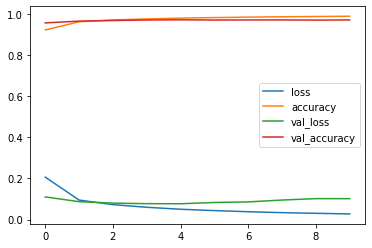

In [31]:
pd.DataFrame(history.history).plot()

In [32]:
y_pred = np.argmax(model.predict(x_test), axis=-1)
y_test = np.argmax(y_test.to_numpy(), axis=1)

In [33]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97     43675
           1       0.96      0.96      0.96     26554
           2       0.97      0.97      0.97     42671
           3       0.98      0.98      0.98     38276

    accuracy                           0.97    151176
   macro avg       0.97      0.97      0.97    151176
weighted avg       0.97      0.97      0.97    151176



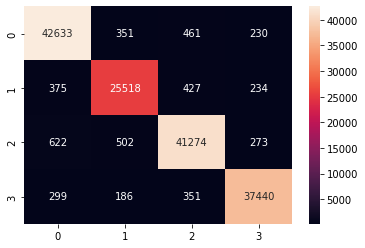

In [34]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, fmt='.0f')

In [35]:
model.save('lstm.h5')